# Figures for the Paper

Python code for generating figures used in the paper "The Frequency
and Sizes of Inner Bars and Nuclear Rings in Barred Galaxies and Their
Dependence on Galaxy Properties" (Erwin 2023, submitted)

## Requirements

This notebook is meant to be run within the full **db-nr_paper** repository, including the associated Python modules and data files.

In addition, this notebook requires, directly or indirectly, the following Python packages:
   * numpy
   * scipy
   * matplotlib

By default, output PDF figure files are *not* saved to disk; to enable this, set the `savePlots` variable in the **Setup** cell to `True` and change the `plotDir` variable (same cell) to point to where you want the figures saved.

## Initial Setup

### General Setup

In [1]:
%matplotlib inline

from matplotlib.pyplot import plot, xlim, ylim, title, legend, xlabel, ylabel
from matplotlib.pyplot import subplots_adjust, text, savefig, gca, clf, hist
from matplotlib.pyplot import loglog, semilogx, semilogy

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20


In [70]:
import copy
# restore "reload" capability to Python 3 (should work for 3.4 and later)
try:
        from importlib import reload
except ImportError:
        pass

import scipy.stats
import numpy as np

# CHANGE THIS TO POINT TO APPROPRIATE LOCAL DIRECTORY (DEFAULT = SAME DIRECTORY AS THIS NOTEBOOK)
# baseDir = "/Users/erwin/Documents/Working/Papers/Paper-extended-wiyn-survey/public/"
baseDir = os.getcwd() + "/"

dataDir = baseDir + "data/"
plotDir = baseDir + "plots/"
sys.path.append(baseDir)

import dbnr_utils
import plotutils as pu
import datautils as du

# unbarredInfoFile = "/Users/erwin/Documents/Working/Papers/Paper-extended-wiyn-survey/sample_unbarred_info_d30b.txt"
unbarredInfoFile = dataDir + "table_unbarred_info.dat"

df_bars, gnames_bars_rowdict = dbnr_utils.GetBarredGalaxyData("table_mainsample.dat", dataDir)
nBarredGalaxies = len(df_bars.name)

s4gdata = du.ReadCompositeTable(dataDir + "s4gbars_table.dat", columnRow=29, dataFrame=True)
nS4G = len(s4gdata.name)

dlines = [line for line in open(unbarredInfoFile) if len(line) > 1 and line[0] != '#']
unbarred_htype_dict = { line.split()[0]: float(line.split()[1]) for line in dlines}
unbarred_gnames = list(unbarred_htype_dict.keys())
unbarred_htypes = np.array([ unbarred_htype_dict[gname] for gname in unbarred_gnames])
nUnbarredGalaxies = len(unbarred_htypes)
nAllGalaxies = nBarredGalaxies + nUnbarredGalaxies


mm = np.arange(8,12,0.01)

# set the following to True in order to save the figures as PDF files
savePlots = False


In [71]:
xtmstar = r"$\log \: (M_{\star} / M_{\odot})$"
xtdist = r"Distance [Mpc]"
ytbarsize_kpc_amax = r"Bar size $a_{\rm max}$ [kpc, deprojected]"
ytbarsize_kpc_Lbar = r"Bar size $L_{\rm bar}$ [kpc, deprojected]"
ytbarsize_kpc_s4g = r"Bar size $a_{\rm vis}$ [kpc, deprojected]"
ytbarsize_kpc_both = r"Bar size $a_{\rm vis}$ or $a_{\rm max}$ [kpc, deprojected]"
ytbarsize_kpc_nr = r"Bar or NR size [kpc, deprojected]"
ytbarsize_kpc_obs = r"Observed bar size $a_{\rm vis}$ [kpc]"


### Useful Functions

In [72]:
def logistic( x, params ):
    """
    Calculates the standard, single-variable logistic function (Bernoulli probability function)
    for x (which can be a scalar or a 1D numpy array).
    
    P(x) = 1 / (1 + exp(-alpha + beta*x))
    
    Parameters
    ----------
    x : float or 1D ndarray of float
        independent (predictor) variable

    params : list or 1D ndarray of float
        parameters for probFn = [alpha, beta]
    
    Returns
    -------
    p : float or 1D ndarray of float
        Bernoulli probability
    """
    alpha, beta = params
    return 1.0 / (1.0 + np.exp(-(alpha + beta*x)))


def logistic_multivar( x_arr, params ):
    """
    Calculates the standard logistic function (Bernoulli probability function)
    for multiple independent variables (x_1, x_2, etc.).
    
    P(x) = 1 / (1 + exp(-alpha + beta_1*x_1 + beta_2*x_2 + ...))
    
    Parameters
    ----------
    x_arr : list of float or 2D ndarray of float
        Independent (predictor) variables, one per *row*. Possible formats:
            [x_1, x_2, x_3], where each x is a scalar float
            [x_1, x_2, x_3], where each x is a 1D ndarray of float
            np.array([x_1, x_2, x_3]) -- x_arr.shape = (nVars, nData)

    params : list or 1D ndarray of float
        parameters for probFn = [alpha, beta_1, beta_2, ...]
    
    Returns
    -------
    p : float or 1D ndarray of float
        Bernoulli probability
    """
    alpha = params[0]
    betas = params[1:]
    expTerm = alpha
    nVars = len(x_arr)
    for i in range(nVars):
        expTerm += betas[i]*x_arr[i]
    return 1.0 / (1.0 + np.exp(-expTerm))


def simplefunc_linear( params, x ):
    """Simple function to compute linear fit: 
        y = alpha + beta*x
    
    Parameters
    ----------
    params : sequence of float
        [alpha, beta]
    x : float or numpy ndarray of float
        x values
    
    Returns
    -------
    y : float or numpy ndarray of float
        y = alpha + beta*x
    """
    alpha = params[0]
    beta = params[1]
    npts = len(x)
    vals = []
    for i in range(npts):
        value = alpha + beta*x[i]
        vals.append(value)
    return np.array(vals)

def simplefunc_brokenlinear( params, x ):
    """
    Computes a broken-linear function:
        y = alpha_1 + beta_1*x.  for x < x_break
        y = alpha_2 + beta_2*x.  for x > x_break
    
    Parameters
    ----------
    params : 1D sequence of float
        [alpha_1, beta_1, x_break, beta_2] for the function
        (note that alpha_2 is computed from the values of the other parameters)
    
    x : float or 1D ndarray of float
        x-values (e.g., log(stellar-mass))
    
    Returns
    -------
    vals : float or 1D ndarray of float
        the value of the broken-linear function at x
    """
    alpha_1 = params[0]
    beta_1 = params[1]
    x_break = params[2]
    beta_2 = params[3]
    alpha_2 = alpha_1 + (beta_1 - beta_2)*x_break
    if (np.iterable(x) == 0):
        x = [x]
    npts = len(x)
    vals = []
    for i in range(npts):
        if x[i] < x_break:
            value = alpha_1 + beta_1*x[i]
        else:
            value = alpha_2 + beta_2*x[i]
        vals.append(value)
    return vals


### Defining subsamples via index vectors

We define different subsamples of barred galaxies (e.g., those that are double-barred, those that are not, etc.) 
via vectors of `int` which function as indices into the various numpy arrays of barred-galaxy parameters (stellar mass, Hubble type, etc.) *or* into the 1322-galaxy, S4G-based parent sample for bar statistics (based on Garcia-Diaz et al. 2016a; see Erwin 2018). The former have name beginning with `ii_`, while the latter have names beginning with `ii_s4g_`.

In [73]:
# Double-barred and not double-barred
ii_db = [i for i in range(nBarredGalaxies) if df_bars.dbFlag[i]]
ii_nondb = [i for i in range(nBarredGalaxies) if i not in ii_db]

# With and without nuclear rings
ii_nr = [i for i in range(nBarredGalaxies) if df_bars.nrFlag[i]]
ii_nonnr = [i for i in range(nBarredGalaxies) if i not in ii_nr]

# subclasses of NR
ii_nr_sf = [i for i in range(nBarredGalaxies) if df_bars.nr_class[i] == "star-forming"]
ii_non_sf_nr = [i for i in range(nBarredGalaxies) if i not in ii_nr_sf]
ii_nr_stellar = [i for i in range(nBarredGalaxies) if df_bars.nr_class[i] == "stellar"]
ii_non_stellar_nr = [i for i in range(nBarredGalaxies) if i not in ii_nr_stellar]
ii_nr_dusty = [i for i in range(nBarredGalaxies) if df_bars.nr_class[i] == "dust"]
ii_non_dusty_nr = [i for i in range(nBarredGalaxies) if i not in ii_nr_dusty]


# NOTE: the following are lists of indices into the 1322-galaxy S4G sample, *not* our 156-galaxy sample!
# Barred and unbarred S4G galaxies, spiral-only S4G
ii_s4g_barred = [i for i in range(nS4G) if s4gdata.sma[i] > 0]
ii_s4g_unbarred = [i for i in range(nS4G) if s4gdata.sma[i] <= 0]
ii_s4g_spirals = [i for i in range(nS4G) if s4gdata.t_s4g[i] > -0.5]
# S4G barred spirals *not* in our sample ("ews" = "Extended WIYN Survey", an old name for the sample)
ii_s4g_barred_non_ews = [i for i in ii_s4g_barred if s4gdata.name[i] not in df_bars.name]
print("Number of galaxies in ii_s4g_barred_non_ews = ", len(ii_s4g_barred_non_ews))

Number of galaxies in ii_s4g_barred_non_ews =  631


## Logistic Regression and Linear-Fit Parameters

These are best-fit parameters from various logistic regressions, done using R [xxx R notebook?]

In [74]:
# Standard logistic regression: alpha,beta for probability of DB or NR as function of log(stellar mass)
coeffs_db_logmstar = [-38.138322797859345, 3.5314830697116486]
coeffs_nr_logmstar = [-32.37282378409543, 2.9810021714670616]

# Standard logistic regression: alpha,beta for probability of DB or NR as function of log(bar semi-major axis)
coeffs_db_amax = [-2.8799470624743986, 3.8243338021684012]
coeffs_nr_amax = [-3.7446577067157727, 5.580708260198873]

# Multivariable logistic regression: alpha, beta_1, beta_2 for probability of 
# DB or NR as function of both log(stellar mass) and log(bar semi-major axis)
coeffs_db_mstaramax = [-29.014651562443085, 2.5623561049406716, 2.511786400144422]
coeffs_nr_mstaramax = [-18.131414108471176, 1.4213011797692052, 4.717473367658021]


These are best-fit paramters from linear fits for log(inner-bar-size) or log(NR-size) vs log(stellar-mass)

## [ ] Figure 1: Isophotes

## Figure 2: DB and NR fraction vs stellar mass

This figure in the paper has two panels; the upper (immediately below) showing fractions for barred galaxies; and the lower (two cells below) for fractions of all galaxies.

### Upper panel: DB and NR fraction vs stellar mass -- barred galaxies

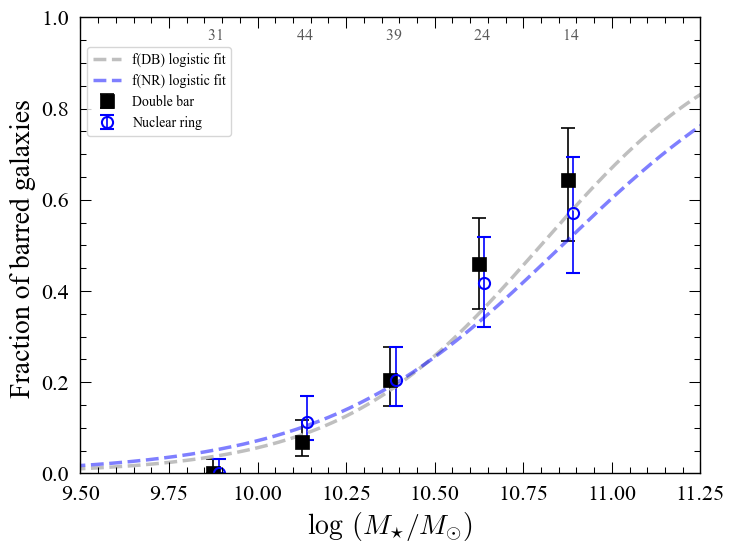

In [75]:
pu.PlotFrequency(df_bars.logmstar, ii_db, ii_nondb, 9.5, 11.25, 0.25, fmt='ks',ms=10,label='Double bar')
pu.PlotFrequency(df_bars.logmstar, ii_nr, ii_nonnr, 9.5, 11.25, 0.25, offset=0.015,noErase=True,
                 fmt='o',mfc='None',mec='blue',color='blue',mew=1.5,ms=8,label="Nuclear ring")
plot(mm, logistic(mm,coeffs_db_logmstar), '0.75', ls='--', lw=2.5, label="f(DB) logistic fit")
plot(mm, logistic(mm,coeffs_nr_logmstar), 'b', alpha=0.5, ls='--', lw=2.5, label="f(NR) logistic fit")
xlim(9.5,11.25);ylim(0,1)

# add bin counts
binranges = np.arange(9.75, 11.25,0.25)
i_all = ii_db + ii_nondb
(n_all, bin_edges) = np.histogram(df_bars.logmstar[i_all], binranges)
n_all_int = [round(n) for n in n_all]
for i in range(len(n_all_int)):
    x = binranges[i]
    n = n_all_int[i]
    text(x + 0.1, 0.95, "%3d" % n, fontsize=11.5, color='0.35')

legend(loc='upper left', bbox_to_anchor=(0,0,1,0.95), fontsize=10)

xlabel(xtmstar);ylabel("Fraction of barred galaxies ")
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir+"fDB-NR_vs_logMstar_barred-galaxies.pdf")

    
# NOTE: to generate the exact version used in the paper, without any x-axis labeling, do the following 
# (to suppress x-axis tick labeling (and also do *not* call xlabel)
#ax = gca()
#ax.set_xticklabels([])


### [ ] Lower panel: DB and NR fraction vs stellar mass -- all galaxies

## Figure 3: NR fractions (different classes) vs stellar mass

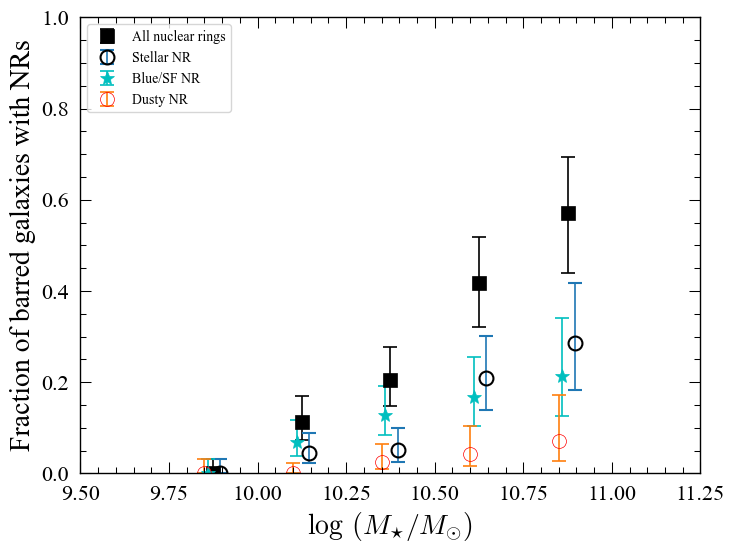

In [76]:
# Just NRs, with subdivisions into different classes

pu.PlotFrequency(df_bars.logmstar, ii_nr, ii_nonnr, 9.5, 11.25, 0.25, fmt='ks', ms=10, 
                 label='All nuclear rings')
pu.PlotFrequency(df_bars.logmstar, ii_nr_stellar, ii_non_stellar_nr, 9.5, 11.25, 0.25, 
                 offset=0.02, noErase=True, fmt='o', mfc='None', mec='k', mew=1.5, ms=10,label='Stellar NR')
pu.PlotFrequency(df_bars.logmstar, ii_nr_sf, ii_non_sf_nr, 9.5, 11.25, 0.25, offset=-0.015, 
                 noErase=True, fmt='c*', ms=10, label='Blue/SF NR')
pu.PlotFrequency(df_bars.logmstar, ii_nr_dusty, ii_non_dusty_nr, 9.5, 11.25, 0.25, offset=-0.025, 
                 noErase=True, fmt='o', mfc='None', mec='r', ms=10, label='Dusty NR')
legend(loc='upper left', fontsize=10)
xlim(9.5,11.25);ylim(0,1)
xlabel(xtmstar);ylabel("Fraction of barred galaxies with NRs")
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir+"fNR_vs_logMstar_NR-classes.pdf")

## Figure 4: DB and NR fractions vs bar size

/var/folders/rj/3r6_hsl93l737byvn_vy_tmm0000gp/T/ipykernel_13901/3704188450.py:28: RuntimeWarning: divide by zero encountered in log10
  return np.log10(x)
/var/folders/rj/3r6_hsl93l737byvn_vy_tmm0000gp/T/ipykernel_13901/3704188450.py:28: RuntimeWarning: divide by zero encountered in log10
  return np.log10(x)


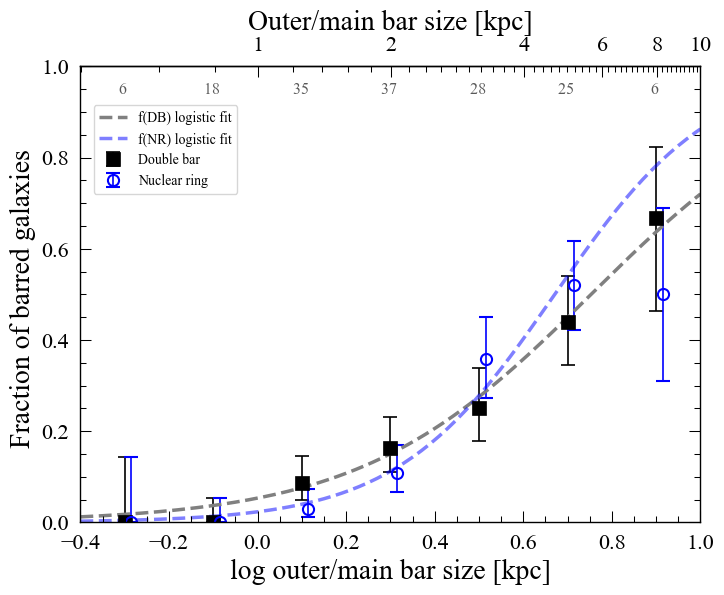

In [77]:
aa = np.arange(-0.4,1.01,0.01)
logamax_dp_kpc = np.log10(df_bars.amax_dp_kpc)
pu.PlotFrequency(logamax_dp_kpc, ii_db, ii_nondb, -0.4,1.2,0.2, fmt='ks',ms=10,label='Double bar')
pu.PlotFrequency(logamax_dp_kpc, ii_nr, ii_nonnr, -0.4,1.2,0.2, offset=0.015,noErase=True,
                 fmt='o',mfc='None',mec='blue',color='blue',mew=1.5,ms=8,label="Nuclear ring")
plot(aa, logistic(aa,coeffs_db_amax), '0.5', ls='--', lw=2.5, label="f(DB) logistic fit")
plot(aa, logistic(aa,coeffs_nr_amax), 'blue', alpha=0.5, ls='--', lw=2.5, label="f(NR) logistic fit")
ylim(0,1)
ylabel("Fraction of barred galaxies ");xlabel("log outer/main bar size [kpc]")


# add bin counts
binranges = np.arange(-0.4,1.2,0.2)
i_all = ii_db + ii_nondb
(n_all, bin_edges) = np.histogram(logamax_dp_kpc[i_all], binranges)
n_all_int = [round(n) for n in n_all]
for i in range(len(n_all_int)):
    x = binranges[i]
    n = n_all_int[i]
    text(x + 0.07, 0.94, "%3d" % n, fontsize=11.5, color='0.35')

legend(loc='upper left', bbox_to_anchor=(0.01,0,1,0.93), fontsize=10)

def axis_to_lin( x ):
    return 10**x

def axis_to_log( x ):
    return np.log10(x)

ax = gca()
ax.tick_params(axis='x', which='both', bottom=True, top=False)
secax = ax.secondary_xaxis('top', functions=(axis_to_lin, axis_to_log))
secax.set_xticks([1.0, 2.0, 4.0, 6.0, 8.0, 10.0])
secax.set_xlabel('Outer/main bar size [kpc]')

subplots_adjust(bottom=0.14)
savefig(baseDir + "fDB-NR_vs_logbarsize.pdf")

## Figure 5: DB fractions (w/ and w/o NR) vs stellar mass

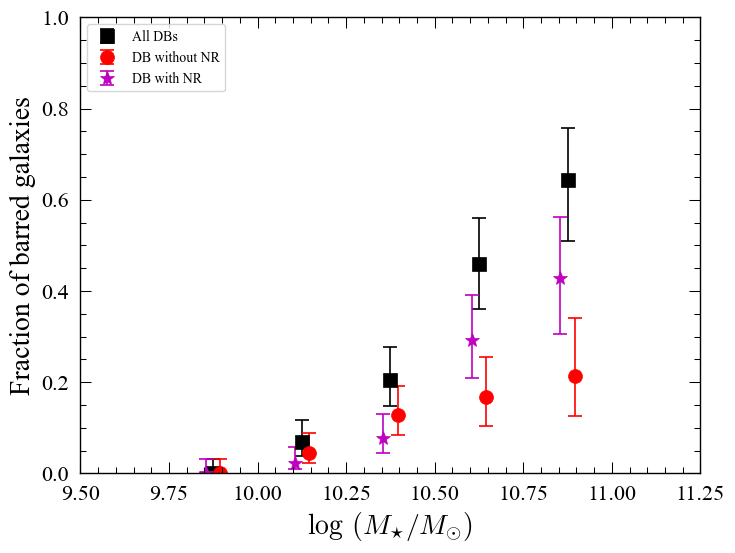

In [78]:
# DB without NR
ii_db_nonnr = [i for i in ii_db if i not in ii_nr]
# all other galaxies (no DB and DB+NR)
ii_non_db_nonnr = [i for i in range(nBarredGalaxies) if i not in ii_db_nonnr]

# DB with NR
ii_db_and_nr = [i for i in ii_db if i in ii_nr]
# NR without DB
ii_nr_nondb = [i for i in ii_nr if i not in ii_db]
# galaxies without DB+NR
ii_non_db_and_nr = [i for i in range(nBarredGalaxies) if i not in ii_db_and_nr]

# NOTE: see cell that makes and saves "fNR_vs_logMstar_all.pdf" for similar plots for NRs
# (all NR, NR w/ or w/o DB)

pu.PlotFrequency(df_bars.logmstar, ii_db, ii_nondb, 9.5, 11.25, 0.25, fmt='ks', ms=10, label='All DBs')
pu.PlotFrequency(df_bars.logmstar, ii_db_nonnr, ii_non_db_nonnr, 9.5, 11.25, 0.25, offset=0.02, 
                 noErase=True, fmt='ro', ms=10, label='DB without NR')
pu.PlotFrequency(df_bars.logmstar, ii_db_and_nr, ii_non_db_and_nr, 9.5, 11.25, 0.25, offset=-0.02, 
                 noErase=True, fmt='m*', ms=10, label='DB with NR')
legend(loc='upper left', fontsize=10)
xlim(9.5,11.25);ylim(0,1)
xlabel(xtmstar);ylabel("Fraction of barred galaxies")
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir+"fDB-with-without-NR_vs_logMstar_all.pdf")

## Figure 6: Multi-variable logistic fit curves

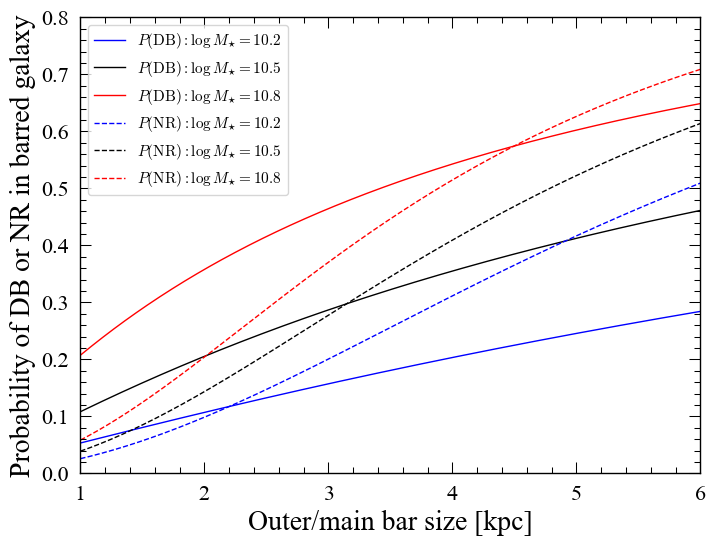

In [79]:
amax_vals = np.arange(1,6.01,0.01)
logamax_vals = np.log10(amax_vals)
nvals = len(amax_vals)

logmstar_vals_102 = np.array([10.2]*nvals)
xx = [logmstar_vals_102, logamax_vals]
p_db_vals_102 = logistic_multivar(xx, coeffs_db_mstaramax)
p_nr_vals_102 = logistic_multivar(xx, coeffs_nr_mstaramax)
logmstar_vals_105 = np.array([10.5]*nvals)
xx = [logmstar_vals_105, logamax_vals]
p_db_vals_105 = logistic_multivar(xx, coeffs_db_mstaramax)
p_nr_vals_105 = logistic_multivar(xx, coeffs_nr_mstaramax)
logmstar_vals_108 = np.array([10.8]*nvals)
xx = [logmstar_vals_108, logamax_vals]
p_db_vals_108 = logistic_multivar(xx, coeffs_db_mstaramax)
p_nr_vals_108 = logistic_multivar(xx, coeffs_nr_mstaramax)

plot(10**logamax_vals, p_db_vals_102, 'b-', label=r"$P({\rm DB}): \log M_{\star} = 10.2$")
plot(10**logamax_vals, p_db_vals_105, 'k-', label=r"$P({\rm DB}): \log M_{\star} = 10.5$")
plot(10**logamax_vals, p_db_vals_108, 'r-', label=r"$P({\rm DB}): \log M_{\star} = 10.8$")
plot(10**logamax_vals, p_nr_vals_102, 'b--', label=r"$P({\rm NR}): \log M_{\star} = 10.2$")
plot(10**logamax_vals, p_nr_vals_105, 'k--', label=r"$P({\rm NR}): \log M_{\star} = 10.5$")
plot(10**logamax_vals, p_nr_vals_108, 'r--', label=r"$P({\rm NR}): \log M_{\star} = 10.8$")
legend(fontsize=11)
ylabel("Probability of DB or NR in barred galaxy");xlabel("Outer/main bar size [kpc]")
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir + "logistic-probs_DB-NR_vs_barsize.pdf")

## Figure 7: DB and NR fractions vs Hubble type

### Upper panel: for barred galaxies

['name', 'dist', 'T', 'logmstar', 'diskPA', 'inclination', 'rotCode', 'barPA', 'amax', 'Lbar', 'emax', 'dbFlag', 'nrFlag', 'bar2PA', 'amax_dp_kpc', 'amax2_dp_kpc', 'nr_dp_kpc', 'nr_class']


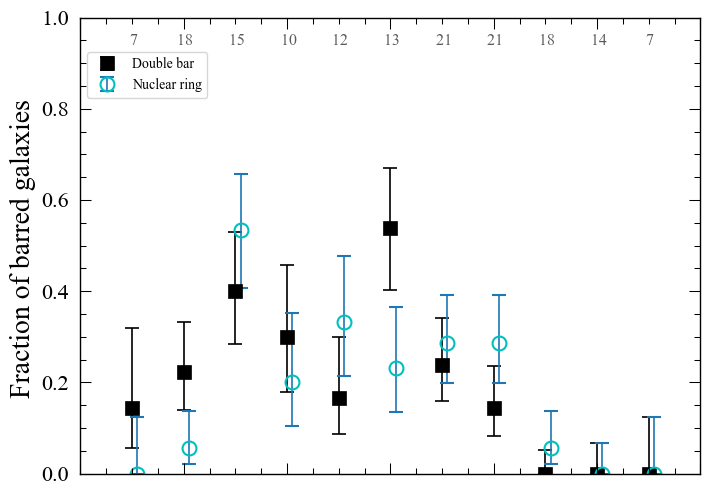

In [80]:
print(df_bars.colNames)
pu.PlotFrequency(df_bars.T, ii_db, ii_nondb, -3.5,8,1, noErase=True, fmt='ks', ms=10, label="Double bar")
pu.PlotFrequency(df_bars.T, ii_nr, ii_nonnr, -3.5,8,1, offset=0.1, noErase=True, fmt='o', mfc='None', mec='c', mew=1.5, ms=10, label="Nuclear ring")

# add bin counts
binranges = np.arange(-3.5,8,1)
i_all = ii_db + ii_nondb
(n_all, bin_edges) = np.histogram(df_bars.T[i_all], binranges)
n_all_int = [round(n) for n in n_all]
for i in range(len(n_all_int)):
    x = binranges[i]
    n = n_all_int[i]
    text(x + 0.3, 0.94, "%3d" % n, fontsize=11.5, color='0.35')

legend(loc='upper left', bbox_to_anchor=(0,0,1,0.94), fontsize=10)

ylim(0,1);xlim(-4,8)
ylabel("Fraction of barred galaxies ")
ax = gca()
ax.set_xticklabels([])
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir+"fDB-NR_vs_Htype_barred-galaxies_no-x-labels.pdf")

# pu.PlotFrequency(df_bars.logmstar, ii_db, ii_nondb, 9.5, 11.25, 0.25, fmt='ks',ms=10,label='Double bar')


### Lower panel: for all galaxies

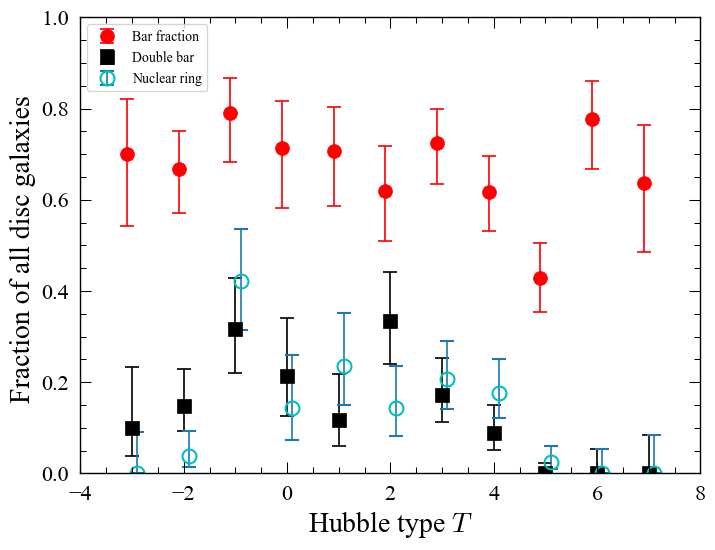

In [81]:
htypes_allGalaxies = np.concatenate((df_bars.T, unbarred_htypes))
ii_nondb_all = [i for i in range(nAllGalaxies) if i not in ii_db]
ii_nonnr_all = [i for i in range(nAllGalaxies) if i not in ii_nr]

pu.PlotFrequency(htypes_allGalaxies, np.arange(0,nBarredGalaxies), 
                 np.arange(nBarredGalaxies,nAllGalaxies), -3.5,8,1, offset=-0.1, fmt='ro', 
                 ms=10, label="Bar fraction")
pu.PlotFrequency(htypes_allGalaxies, ii_db, ii_nondb_all, -3.5,8,1, noErase=True, fmt='ks', ms=10, label="Double bar")
pu.PlotFrequency(htypes_allGalaxies, ii_nr, ii_nonnr_all, -3.5,8,1, offset=0.1, noErase=True, fmt='o', mfc='None', mec='c', mew=1.5, ms=10, label="Nuclear ring")
ylim(0,1);xlim(-4,8)
legend(fontsize=10)
xlabel("Hubble type $T$");ylabel("Fraction of all disc galaxies ")
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir+"fDB-NR_vs_Htype_all-galaxies.pdf")


## Figure 8: Bar-size measurements: This paper vs S4G

In [82]:
# Defining the set of our ("ews") galaxies that are in S4G
# first = indices into S4G; second = indices into ews_barred_gnames_d30
ii_s4g_ews_in_s4g = []   # index into S4G
ii_ews_in_s4g = []       # index into EWS (of galaxies in S4G)
for i in range(nBarredGalaxies):
    gname = df_bars.name[i]
    if gname in s4gdata.name:
        ii_ews_in_s4g.append(i)
        ii = [i for i in range(nS4G) if s4gdata.name[i] == gname][0]
        ii_s4g_ews_in_s4g.append(ii)

# our observed bar amax
amax_obs_arcsec = []
lbar_obs_arcsec = []
s4g_avis_obs_arcsec = []
gnames_size_vs_s4g = []
for n in range(len(ii_ews_in_s4g)):
    iii_in_ews = ii_ews_in_s4g[n]
    iii_in_s4g = ii_s4g_ews_in_s4g[n]
    if s4gdata.sma[iii_in_s4g] > 0:
        # only keep results if S4G has a valid bar size
        s4g_avis_obs_arcsec.append(s4gdata.sma[iii_in_s4g])
        amax_obs_arcsec.append(df_bars.amax[iii_in_ews])
        lbar_obs_arcsec.append(df_bars.Lbar[iii_in_ews])

# Fix NGC2681: use middle bar for EWS measurements
iii = [i for i in range(len(df_bars.name)) if df_bars.name[i] == "NGC2681"][0]
amax_obs_arcsec[iii] = 18.0
lbar_obs_arcsec[iii] = 19.0

### Upper panel of figure (no x-axis label)

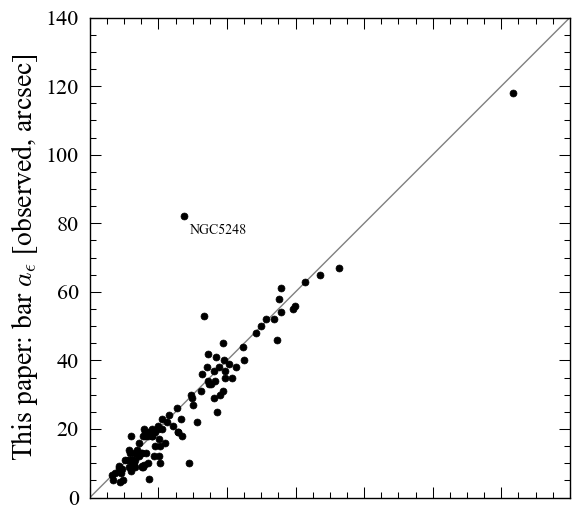

In [83]:
plot([0,140],[0,140], color='0.5')
plot(s4g_avis_obs_arcsec, amax_obs_arcsec, 'ko', ms=5)
ylabel(r"This paper: bar $a_{\epsilon}$ [observed, arcsec]")
#xlabel(r"S4G $a_{\rm vis}$ [observed, arcsec]")
text(29,77, 'NGC5248', fontsize=10)
ax = gca()
ax.set_box_aspect(1)
ax.set_xticklabels([])
if savePlots:
    savefig(baseDir+"s4g-avis_vs_amax.pdf")


### Lower panel of figure

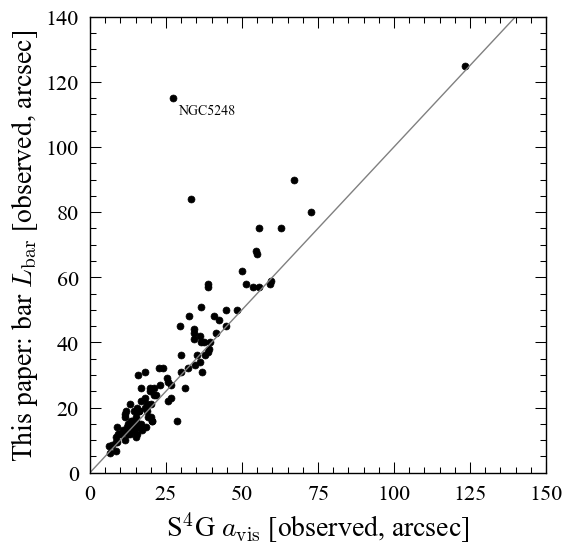

In [84]:
plot(s4g_avis_obs_arcsec, lbar_obs_arcsec, 'ko', ms=5)
plot([0,140],[0,140], color='0.5')
ylabel(r"This paper: bar $L_{\rm bar}$ [observed, arcsec]")
xlabel(r"S$^{4}$G $a_{\rm vis}$ [observed, arcsec]")
text(29,110, 'NGC5248', fontsize=10)
ax = gca()
ax.set_box_aspect(1)
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir+"s4g-avis_vs_Lbar.pdf")


## Figure 9: Bar sizes vs stellar mass

7 ['S4G (spirals)', 'Outer bars of DB', 'Inner bars of DB', 'Sample outer or single bars', 'NGC 2681', 'Erwin 2019: S4G spiral trend', 'DB inner-bar trend']


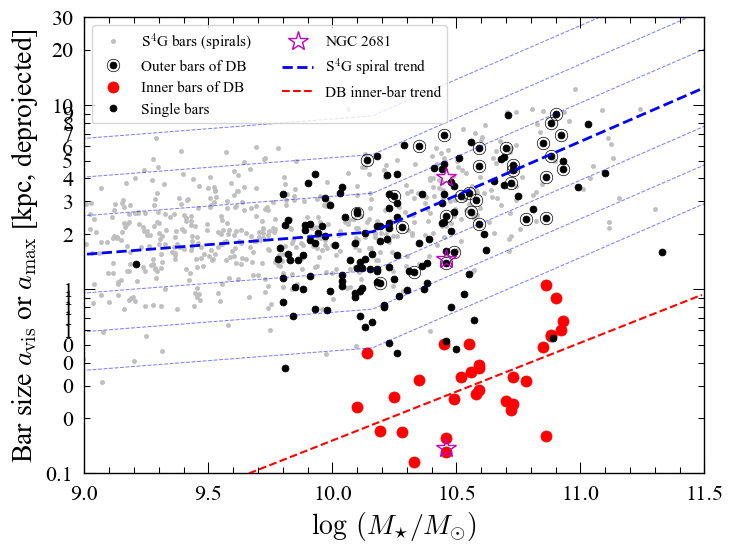

In [85]:
mm_db = np.arange(9.0,11.5,0.01)

# fit from Table 2 of Erwin (2019), "Parent Sample" (D < 30 Mpc, logMstar = 9--11)
params_brokenlinear = [-0.75923683,   0.10541102,  10.1620274 ,   0.58544685]
fitline_sigma = 0.21   # See Section 4.05 of "barsize-vs-mstar-etc." Jupyter notebook

# plot all barred galaxies from S4G ("Parent disc" in Erwin 2019), *except* for those in this paper's sample
s4gbars = semilogy(s4gdata.logmstar[ii_s4g_barred_non_ews], s4gdata.sma_dp_kpc2[ii_s4g_barred_non_ews], 'o', ms=3, color='0.75', label='S4G (spirals)')
# plot this paper's sample
semilogy(df_bars.logmstar[ii_db], df_bars.amax_dp_kpc[ii_db], 'o', mfc='None', mec='k', ms=9, label='Outer bars of DB')
semilogy(df_bars.logmstar[ii_db], df_bars.amax2_dp_kpc[ii_db], 'ro', ms=8, label='Inner bars of DB')
semilogy(df_bars.logmstar, df_bars.amax_dp_kpc, 'ko', ms=5, label='Sample outer or single bars')

# NGC 2681 triple bar: log(M_star) = 10.456, semi-major axes of bars = 0.138, 1.457, 4.048 kpc
n2681bars = semilogy([10.456]*3, [0.138, 1.457, 4.048], '*',mfc='None',mec='m', mew=1, ms=15, label='NGC 2681')

fitline_log = np.array(simplefunc_brokenlinear(params_brokenlinear, mm))
s4g_trendline = plot(mm, 10**fitline_log, 'b--', lw=2, label="Erwin 2019: S4G spiral trend")
plot(mm, 10**(fitline_log + fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log - fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log + 2*fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log - 2*fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log + 3*fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log - 3*fitline_sigma), 'b--', lw=0.75, alpha=0.5)
ib_fitline_log = simplefunc_linear([-6.13152, 0.530989], mm_db)
plot(mm_db, 10**ib_fitline_log, 'r--', lw=1.5, zorder=3, label="DB inner-bar trend")
xlim(9,11.5);ylim(0.1,30)

handles, labels = gca().get_legend_handles_labels()
print(len(handles), labels)
handles_new = [handles[0], (handles[1], handles[3]), handles[2], handles[3], handles[4], handles[5], handles[6]]
labels_new = ["S$^{4}$G bars (spirals)", "Outer bars of DB", "Inner bars of DB", "Single bars",
               "NGC 2681", "S$^{4}$G spiral trend", "DB inner-bar trend"]
legend(handles_new, labels_new, loc='upper left', fontsize=11, ncols=2)
xlabel(xtmstar);ylabel(ytbarsize_kpc_both)
pu.MakeNiceLogAxes(whichAxis="y")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir + "bar_amax_vs_Mstar_with-s4g_db_v3.pdf")

## Figure 10: NR and Bar sizes vs stellar mass

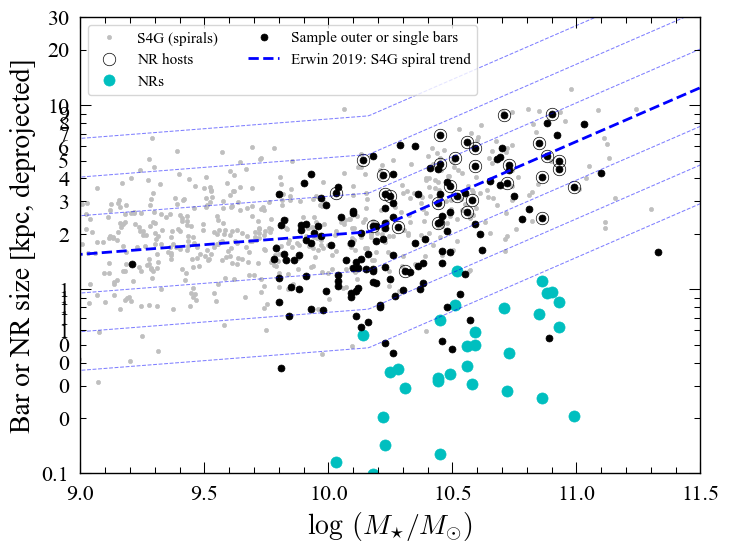

In [86]:
# plot all barred galaxies from S4G ("Parent disc" in Erwin 2019), *except* for those in our sample
semilogy(s4gdata.logmstar[ii_s4g_barred_non_ews], s4gdata.sma_dp_kpc2[ii_s4g_barred_non_ews], 'o', ms=3, color='0.75', label='S4G (spirals)')
# plot NRs and NR host gars
#semilogy(df_bars.logmstar[ii_db], df_bars.amax_dp_kpc[ii_db], 'o', mfc='None', mec='k', ms=9, label='Outer bars of DB')
semilogy(df_bars.logmstar[ii_nr], df_bars.amax_dp_kpc[ii_nr], 'o', mfc='None', mec='k', ms=9, label='NR hosts')
semilogy(df_bars.logmstar[ii_nr], df_bars.nr_dp_kpc[ii_nr], 'co', ms=8, label='NRs')
semilogy(df_bars.logmstar, df_bars.amax_dp_kpc, 'ko', ms=5, label='Sample outer or single bars')

plot(mm, 10**fitline_log, 'b--', lw=2, label="Erwin 2019: S4G spiral trend")
plot(mm, 10**(fitline_log + fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log - fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log + 2*fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log - 2*fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log + 3*fitline_sigma), 'b--', lw=0.75, alpha=0.5)
plot(mm, 10**(fitline_log - 3*fitline_sigma), 'b--', lw=0.75, alpha=0.5)
xlim(9,11.5);ylim(0.1,30)
legend(loc='upper left', fontsize=11, ncols=2)
xlabel(xtmstar);ylabel(ytbarsize_kpc_nr)
pu.MakeNiceLogAxes(whichAxis="y")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir + "bar_amax_vs_Mstar_with-nr.pdf")

## Figure 11: IB and NR size vs host bar size

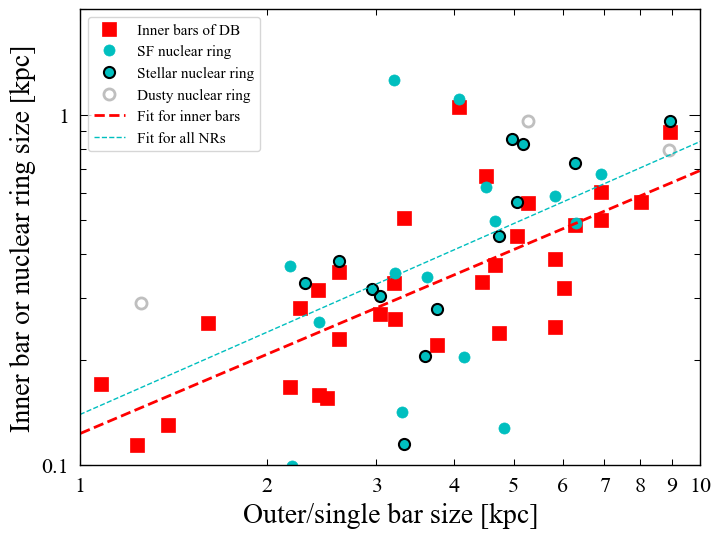

In [87]:
aa = np.arange(-1.0, 1.01, 0.01)

# fit from Table 2 of Erwin (2019), "Parent Sample" (D < 30 Mpc, logMstar = 9--11)
params_ib_vs_ob = [-0.90893764, 0.75041109]
params_nr_vs_ob = [-0.85439353, 0.77862487]

loglog(df_bars.amax_dp_kpc[ii_db], df_bars.amax2_dp_kpc[ii_db], 'rs', ms=10, label='Inner bars of DB')

ii_nr_st_sf = ii_nr_stellar + ii_nr_sf
loglog(df_bars.amax_dp_kpc[ii_nr_st_sf], df_bars.nr_dp_kpc[ii_nr_st_sf], 'co', ms=8, label='All nuclear rings')
loglog(df_bars.amax_dp_kpc[ii_nr_stellar], df_bars.nr_dp_kpc[ii_nr_stellar], 'o', ms=8, mfc='None', mec='k',
       mew=1.5, label='Stellar nuclear rings')
loglog(df_bars.amax_dp_kpc[ii_nr_dusty], df_bars.nr_dp_kpc[ii_nr_dusty], 'o', ms=8, mfc='None', mec='0.75',
       mew=2, label='Dusty nuclear rings')

loglog(10**aa, 10**np.array(simplefunc_linear(params_ib_vs_ob, aa)), 'r--', lw=2, label="Fit for inner bars")
loglog(10**aa, 10**np.array(simplefunc_linear(params_nr_vs_ob, aa)), 'c--', lw=1.0, label="Fit for all NRs")

# Inner bar;    SF NR;         stellar NR;                       dusty
# red square;   cyan circle;   cyan circle + black circle;       open gray
handles, labels = gca().get_legend_handles_labels()
# let's say the 2nd and 3rd symbols form the combined symbol
handles_new = [handles[0], handles[1], (handles[1], handles[2]), handles[3], handles[4], handles[5]]
labels_new =  ["Inner bars of DB",  "SF nuclear ring", "Stellar nuclear ring", "Dusty nuclear ring", labels[4], labels[5]]

legend(handles_new, labels_new, loc='upper left', fontsize=11)

xlim(1,10);ylim(0.1,2)
xlabel(r"Outer/single bar size [kpc]");ylabel(r"Inner bar or nuclear ring size [kpc]")
pu.MakeNiceLogAxes(whichAxis="x")
pu.MakeNiceLogAxes(whichAxis="y", minor=False)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
subplots_adjust(bottom=0.14)
if savePlots:
    savefig(baseDir + "inner-bar-nr-size_vs_bar-size.pdf")

## Figure 12: Relative position angles between inner and outer bars

**TODO:** 

   * [ ] Add CW/CCW rotation code to df_bars

   * [ ] Add inner-bar observed PA to df_bars


In [34]:
deltaPA_dp = []
deltaPA_db_abs = []
for i in ii_db:
    #g = barredGalaxiesArray_d30[i]
    diskPA = df_bars.diskPA[i]
    inclination = df_bars.inclination[i]
    rotCode_str = df_bars.rotCode[i]
    if rotCode_str == "+":
        rotCode = 1
    elif rotCode_str == "-":
        rotCode = -1
    else:
        rotCode = None
    bar1PA = df_bars.barPA[i]
    bar1PA_dp = dbnr_utils.deprojectpa_abs(bar1PA, diskPA, inclination)
# [ ]    bar2PA_dp = angles.deprojectpa_abs(g.bar2PA, diskPA, inclination)
    bar2PA = df_bars.bar2PA[i]
    if rotCode in [-1,1]:
        dPA_dp = db_utils.DiffAngle(bar2PA, bar1PA, rotCode, diskPA, inclination)
        deltaPA_dp.append(dPA_dp)

deltaPA_dp = np.array(deltaPA_dp)
print("N_tot (DB with leading/trailing data) = {0}".format(len(deltaPA_dp)))
print("N_trailing = {0}, N_leading = {1}".format(len([x for x in deltaPA_dp if x < 0]), 
                                                 len([x for x in deltaPA_dp if x > 0])))

clf();hist(deltaPA_dp, bins=np.arange(-90,100,10), histtype='step', color='k');ylim(0,6)
xlabel(r"trailing      $\Delta$PA      leading");ylabel("$N$")
if savePlots:
    savefig(baseDir + "DB_deltaPA_histogram.pdf")

# K-S test vs uniform distribution
# remap the PA range from (-90,90) to (0,1) to compare with default output of scipy.stats.uniform.cdf
deltaPA_remapped = (deltaPA_dp + 90)/180
scipy.stats.kstest(deltaPA_remapped, scipy.stats.uniform.cdf)


NameError: name 'g' is not defined